# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Get aging model

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import training
import PNN_Setting as ps
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Prepare data

## Load data

In [2]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'PMLC',
                        'data_processed', 'Dataset_Pendigits.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']
M, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, M, N_features, N_class

(torch.Size([10992, 16]), torch.Size([10992]), 10992, 16, 10)

## data preprocessing

In [3]:
# normalization
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [4]:
X[:10, :9]

tensor([[0.4700, 1.0000, 0.2700, 0.8100, 0.5700, 0.3700, 0.2600, 0.0000, 0.0000],
        [0.0000, 0.8900, 0.2700, 1.0000, 0.4200, 0.7500, 0.2900, 0.4500, 0.1500],
        [0.0000, 0.5700, 0.3100, 0.6800, 0.7200, 0.9000, 1.0000, 1.0000, 0.7600],
        [0.0000, 1.0000, 0.0700, 0.9200, 0.0500, 0.6800, 0.1900, 0.4500, 0.8600],
        [0.0000, 0.6700, 0.4900, 0.8300, 1.0000, 1.0000, 0.8100, 0.8000, 0.6000],
        [1.0000, 1.0000, 0.8800, 0.9900, 0.4900, 0.7400, 0.1700, 0.4700, 0.0000],
        [0.0000, 1.0000, 0.0300, 0.7200, 0.2600, 0.3500, 0.8500, 0.3500, 1.0000],
        [0.0000, 0.3900, 0.0200, 0.6200, 0.1100, 0.0500, 0.6300, 0.0000, 1.0000],
        [0.1300, 0.8900, 0.1200, 0.5000, 0.7200, 0.3800, 0.5600, 0.0000, 0.0400],
        [0.5700, 1.0000, 0.2200, 0.7200, 0.0000, 0.3100, 0.2500, 0.0000, 0.7500]])

In [5]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X, y)

# split
train_rate = 0.6
test_rate = 0.2
M_train = int(M*train_rate)
M_test = int(M*test_rate)
train_data, rest_data = random_split(dataset, [M_train, M-M_train], generator=torch.Generator().manual_seed(19950102))
test_data, valid_data = random_split(rest_data, [M_test, M-M_train-M_test], generator=torch.Generator().manual_seed(19950102))
len(train_data), len(test_data), len(valid_data)

(6595, 2198, 2199)

In [6]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [7]:
N_Hidden = 16
m = 0.3
T = 0.1
K = 5  # number of time sampling
M = 40  # number of model sampling
K_test = 5
M_test = 10

# Normal NN
## Training

In [8]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                         torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


NN.apply(weights_init)

optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
celoss = torch.nn.CrossEntropyLoss()
NN

Sequential(
  (0): Linear(in_features=16, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=10, bias=True)
  (3): Tanh()
)

In [9]:
train_loss_NN, test_loss_NN, parameter_NN = training.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.07188 | Loss: 2.379674673 |
| Epoch:   100 | Accuracy: 0.81210 | Loss: 1.142799139 |
| Epoch:   200 | Accuracy: 0.84713 | Loss: 1.017530799 |
| Epoch:   300 | Accuracy: 0.90537 | Loss: 0.965335011 |
| Epoch:   400 | Accuracy: 0.93949 | Loss: 0.917653263 |
| Epoch:   500 | Accuracy: 0.94950 | Loss: 0.895352542 |
| Epoch:   600 | Accuracy: 0.95541 | Loss: 0.882164061 |
| Epoch:   700 | Accuracy: 0.95905 | Loss: 0.872920096 |
| Epoch:   800 | Accuracy: 0.96451 | Loss: 0.865280330 |
| Epoch:   900 | Accuracy: 0.96952 | Loss: 0.860008776 |
| Epoch:  1000 | Accuracy: 0.97179 | Loss: 0.855922818 |
| Epoch:  1100 | Accuracy: 0.97452 | Loss: 0.851984978 |
| Epoch:  1200 | Accuracy: 0.97589 | Loss: 0.848673999 |
| Epoch:  1300 | Accuracy: 0.97543 | Loss: 0.846331418 |
| Epoch:  1400 | Accuracy: 0.97634 | Loss: 0.844464719 |
| Epoch:  1500 | Accuracy: 0.97634 | Loss: 0.843116581 |
| Epoch:  1600 | Accuracy: 0.97634 | Loss: 0.842296600 |
| Epoch:  1700 | Accuracy: 0.97

(3591, tensor(0.8350))

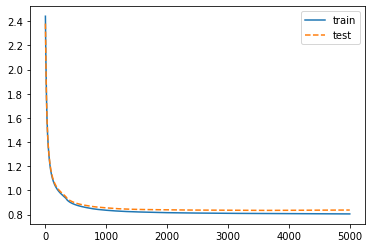

In [10]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## save model

In [11]:
torch.save(NN, f'./pendigitresult/NN_16.pkl')

## load model

In [12]:
NN = torch.load(f'./pendigitresult/NN_16.pkl')

## evalutation

In [13]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.numpy()) / y_valid.shape[0]
print(acc_valid)

0.98681218735789


# PNN
## Training

In [14]:
PNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                          pnn.PNNLayer(N_Hidden, N_class, age_generator))
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
PNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

In [15]:
train_loss_PNN, test_loss_PNN, parameter_PNN = training.train_normal_pnn(
    PNN, train_loader, test_loader, m, T, optimizer_PNN, pnn.LossFunction, 15000)

  0%|          | 0/15000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.09736 | Loss: 1.395999962 |
| Epoch:   100 | Accuracy: 0.09736 | Loss: 1.286594062 |
| Epoch:   200 | Accuracy: 0.71247 | Loss: 0.548701108 |
| Epoch:   300 | Accuracy: 0.80710 | Loss: 0.344741243 |
| Epoch:   400 | Accuracy: 0.87125 | Loss: 0.245195877 |
| Epoch:   500 | Accuracy: 0.90355 | Loss: 0.202007473 |
| Epoch:   600 | Accuracy: 0.92038 | Loss: 0.176154780 |
| Epoch:   700 | Accuracy: 0.93267 | Loss: 0.160624584 |
| Epoch:   800 | Accuracy: 0.94040 | Loss: 0.149430897 |
| Epoch:   900 | Accuracy: 0.94495 | Loss: 0.140401894 |
| Epoch:  1000 | Accuracy: 0.94677 | Loss: 0.134133630 |
| Epoch:  1100 | Accuracy: 0.94904 | Loss: 0.128810101 |
| Epoch:  1200 | Accuracy: 0.95041 | Loss: 0.124364490 |
| Epoch:  1300 | Accuracy: 0.95041 | Loss: 0.121059781 |
| Epoch:  1400 | Accuracy: 0.95086 | Loss: 0.118143039 |
| Epoch:  1500 | Accuracy: 0.95177 | Loss: 0.115529849 |
| Epoch:  1600 | Accuracy: 0.95177 | Loss: 0.112966574 |
| Epoch:  1700 | Accuracy: 0.95

(11367, tensor(0.0654, dtype=torch.float64))

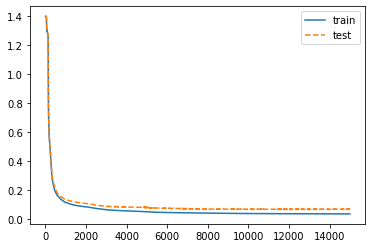

In [16]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## save PNN

In [17]:
torch.save(PNN, f'./pendigitresult/PNN_16.pkl')

## load PNN

In [18]:
PNN = torch.load(f'./pendigitresult/PNN_16.pkl')

## Functions for setting times and models

In [19]:
import PNN_Setting as ps
# ps.makemodel
# ps.settime
# ps.zerogradient

Usage of functions: 

`pnn.apply(lambda z: settime(z, time))`

`pnn.apply(makemodel)`

`pnn.apply(zerogradient)`

## evaluation

In [24]:
import evaluation
importlib.reload(evaluation)
mean_acc_PNN, std_acc_PNN, mean_maa_PNN, std_maa_PNN = evaluation.FullEvaluation(PNN, valid_loader)

  0%|          | 0/500 [00:00<?, ?it/s]

evaluating on the 0-th model.
evaluating on the 10-th model.
evaluating on the 20-th model.
evaluating on the 30-th model.
evaluating on the 40-th model.
evaluating on the 50-th model.
evaluating on the 60-th model.
evaluating on the 70-th model.
evaluating on the 80-th model.
evaluating on the 90-th model.
evaluating on the 100-th model.
evaluating on the 110-th model.
evaluating on the 120-th model.
evaluating on the 130-th model.
evaluating on the 140-th model.
evaluating on the 150-th model.
evaluating on the 160-th model.
evaluating on the 170-th model.
evaluating on the 180-th model.
evaluating on the 190-th model.
evaluating on the 200-th model.
evaluating on the 210-th model.
evaluating on the 220-th model.
evaluating on the 230-th model.
evaluating on the 240-th model.
evaluating on the 250-th model.
evaluating on the 260-th model.
evaluating on the 270-th model.
evaluating on the 280-th model.
evaluating on the 290-th model.
evaluating on the 300-th model.
evaluating on the 3

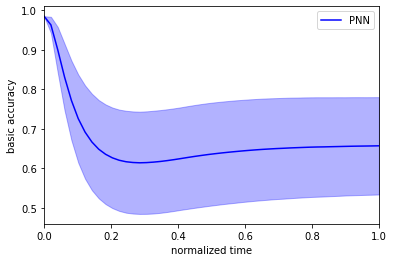

In [27]:
plt.fill_between(np.linspace(0,1,50), mean_acc_PNN-std_acc_PNN, mean_acc_PNN+std_acc_PNN, alpha=0.3, color='blue');
plt.plot(np.linspace(0,1,50), mean_acc_PNN, label='PNN', color='blue');

plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

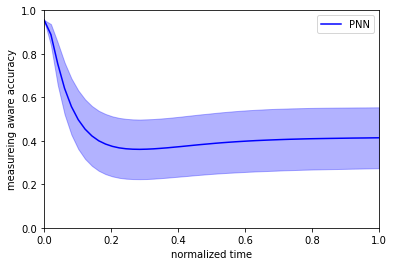

In [29]:
plt.fill_between(np.linspace(0,1,50), mean_maa_PNN-std_maa_PNN, mean_maa_PNN+std_maa_PNN, alpha=0.3, color='blue');
plt.plot(np.linspace(0,1,50), mean_maa_PNN, label='PNN', color='blue');

plt.xlabel('normalized time');
plt.ylabel('measureing aware accuracy');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.legend();

# Aging Aware PNN
## Training

In [30]:
AAPNN = torch.nn.Sequential(pnn.PNNLayer(N_features, N_Hidden, age_generator),
                            pnn.PNNLayer(N_Hidden, N_class, age_generator))

optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
AAPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

### Functions for generating parallel AAPNNs

In [31]:
# ps.MakeParallelPNNs
# ps.MakeParallelModels

Usage:

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M, K)`, generating different models & different time stamps

`Parallel_PNNs = ps.MakeParallelPNNs(pnn, M)`, generating only different models

# Load temp parameter when corrupt

In [ ]:
with open('./temp/parameter_AAPNN.p', 'rb') as f:
    parameter_AAPNN = pickle.load(f)
AAPNN.load_state_dict(parameter_AAPNN);

## Parallel Training

In [ ]:
importlib.reload(training)
test_loss_AAPNN, parameter_AAPNN = training.ParallelTrainingAAPNN(AAPNN,
                                                                  train_loader, test_loader,
                                                                  optimizer_AAPNN,
                                                                  pnn.LossFunction, m, T,
                                                                  M, K, M_test, K_test, Epoch=700)

  0%|          | 0/700 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.10622 | Loss: 1.382777019 |
| Epoch:    10 | Accuracy: 0.09910 | Loss: 1.329974995 |
| Epoch:    20 | Accuracy: 0.09967 | Loss: 1.222981979 |
| Epoch:    30 | Accuracy: 0.15876 | Loss: 1.142200220 |
| Epoch:    40 | Accuracy: 0.16734 | Loss: 1.150092956 |
| Epoch:    50 | Accuracy: 0.21095 | Loss: 1.002080224 |
| Epoch:    60 | Accuracy: 0.28663 | Loss: 0.935304863 |
| Epoch:    70 | Accuracy: 0.33944 | Loss: 0.938138557 |
| Epoch:    80 | Accuracy: 0.39572 | Loss: 0.867188498 |
| Epoch:    90 | Accuracy: 0.43229 | Loss: 0.889953695 |
| Epoch:   100 | Accuracy: 0.37570 | Loss: 0.917554183 |
| Epoch:   110 | Accuracy: 0.52241 | Loss: 0.729977653 |
| Epoch:   120 | Accuracy: 0.56468 | Loss: 0.693440481 |
| Epoch:   130 | Accuracy: 0.58574 | Loss: 0.706042524 |
| Epoch:   140 | Accuracy: 0.63203 | Loss: 0.637532476 |
| Epoch:   150 | Accuracy: 0.64719 | Loss: 0.601378466 |
| Epoch:   160 | Accuracy: 0.67071 | Loss: 0.573884424 |
| Epoch:   170 | Accuracy: 0.67

In [ ]:
plt.plot(test_loss_AAPNN);
AAPNN.load_state_dict(parameter_AAPNN);

## save AAPNN

In [ ]:
torch.save(AAPNN, f'./pendigitresult/AAPNN_16.pkl')

## read AAPNN

In [ ]:
AAPNN = torch.load(f'./pendigitresult/AAPNN_16.pkl')

## Evaluation

In [ ]:
mean_acc_AAPNN, std_acc_AAPNN, mean_maa_AAPNN, std_maa_AAPNN = evaluation.FullEvaluation(AAPNN, valid_loader)

In [ ]:
plt.fill_between(np.linspace(0,1,50), mean_acc_AAPNN-std_acc_AAPNN, mean_acc_AAPNN+std_acc_AAPNN, alpha=0.3, color='red');
plt.plot(np.linspace(0,1,50), mean_acc_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

In [ ]:
plt.fill_between(np.linspace(0,1,50), mean_maa_AAPNN-std_maa_AAPNN, mean_maa_AAPNN+std_maa_AAPNN, alpha=0.3, color='red');
plt.plot(np.linspace(0,1,50), mean_maa_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('measureing aware accuracy');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.legend();

# Comparison

In [ ]:
plt.fill_between(test_time, mean_acc_PNN-std_acc_PNN, mean_acc_PNN+std_acc_PNN, alpha=0.3, color='blue');
plt.fill_between(test_time, mean_acc_AAPNN-std_acc_AAPNN, mean_acc_AAPNN+std_acc_AAPNN, alpha=0.3, color='red');

plt.plot(test_time, mean_acc_PNN, label='PNN', color='blue');
plt.plot(test_time, mean_acc_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.legend();

In [ ]:
plt.fill_between(test_time, mean_maa_PNN-std_maa_PNN, mean_maa_PNN+std_maa_PNN, alpha=0.3, color='blue');
plt.fill_between(test_time, mean_maa_AAPNN-std_maa_AAPNN, mean_maa_AAPNN+std_maa_AAPNN, alpha=0.3, color='red');

plt.plot(test_time, mean_maa_PNN, label='PNN', color='blue');
plt.plot(test_time, mean_maa_AAPNN, label='AAPNN', color='red');

plt.xlabel('normalized time');
plt.ylabel('measureing aware accuracy');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.legend();